In [2]:
import os

from numpy import save
import numpy as np
import random

import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset

import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from models.DDPM import Unet, GaussianDiffusion, LitModelDDPM

from utils.dataset import import_dataset

import argparse

import mlflow

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger

from utils.drone_dataset import DroneDatasetTiled, DroneDataset, create_tiles_segmentation
from utils.base import load_image, split_mosaic, inv_split_mosaic

os.umask(0o002)

2

In [7]:
import pytorch_lightning as pl
pl.__version__

'1.5.3'

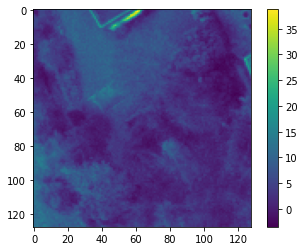

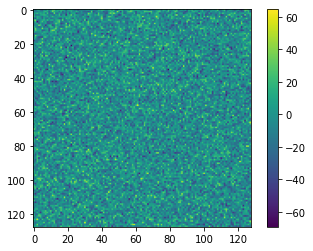

In [5]:
from utils.drone_dataset import import_drone
    
train_loader, valid_loader = import_drone(256,256,32)

x,y = next(iter(train_loader))

plt.figure()
plt.imshow(x[0,0].cpu())
plt.colorbar()
plt.figure()
plt.imshow(y[0,0].cpu())
plt.colorbar()

In [20]:
tracking_uri='http://mlflowroute-2587054aproject.ida.dcs.gla.ac.uk/'
experiment_name='conditionalDDPM'
run_name='DroneTest'

dataset='drone'

timesteps=4000
train_num_steps=30000

loss='l2'
dim=128
n_layers=4
batch_size=32
lr=2e-05
device='cuda:0'

mode='train'
model_type='c'
save_loss_every=50

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

x,y = next(iter(train_loader))

if dataset.startswith('ls'):
    if dataset.endswith('full'):
        _, channels, steps, height, width = x.shape
    else:
        _, channels, height, width = x.shape
else:
    _, channels, height, width = x.shape
assert height == width, 'Image should be square'
image_size = height
condition_dim = 1 if y.ndim == 1 else channels
dim_mults = [2**i for i in range(n_layers)]

# Define Model

"""Define NN"""
model = Unet(
    dim = dim,
    dim_mults = dim_mults,
    channels = channels if model_type == 'unc' else channels+condition_dim,
    out_dim = channels, 
)

"""Define DDPM"""
diffusion = GaussianDiffusion(
                model,
                image_size = image_size,
                timesteps = timesteps,   
                loss_type = loss,  
                channels = channels,
                model_type = model_type,
                device = device
                )

"""Define Pytorch Lightning Model"""
model = LitModelDDPM( 
                diffusion_model = diffusion, 
                model_type = model_type,
                batch_size = batch_size,
                lr = lr,
                save_loss_every = save_loss_every
                )

"""Define Logger"""
mlf_logger = MLFlowLogger(tracking_uri=tracking_uri,
                          experiment_name=experiment_name, 
                          run_name=run_name
                         )

run_id = mlf_logger.run_id

# for key in list(args.__dict__.keys()):
#     mlf_logger.experiment.log_param(run_id=run_id, key=key, value=getattr(args, key))

"""Define Trainer"""
trainer = Trainer(
                 enable_checkpointing=False,
                 logger=mlf_logger,
                 max_steps = train_num_steps,
                 limit_val_batches=1,
                 limit_test_batches=1,
                 log_every_n_steps=50,
                 num_sanity_val_steps=0,
                 gpus=1 if device == 'cuda:0' else 0)

"""Train the model"""
trainer.fit(
        model,
        train_dataloaders=train_loader
)

"""Save Results at the end of the training"""

trainer.test(
        model,
        dataloaders=valid_loader
)

2022/05/26 17:45:40 WARNING mlflow.tracking.context.registry: Encountered unexpected error during resolving tags: 'getpwuid(): uid not found: 1001030000'
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | GaussianDiffusion | 117 M 
--------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
468.778   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [46]:
batch_size=1

x,y = next(iter(train_loader))
x=x[0][None]
y=y[0][None]
trainer.model.model.to('cuda:0')
pred = trainer.model.model.sample(y.cuda(),batch_size)

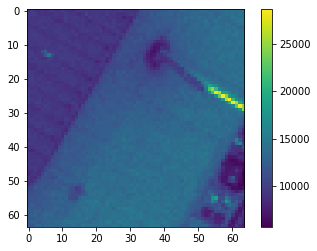

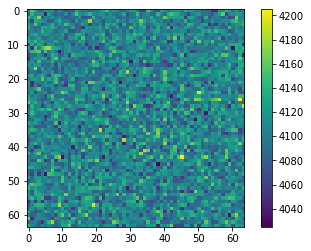

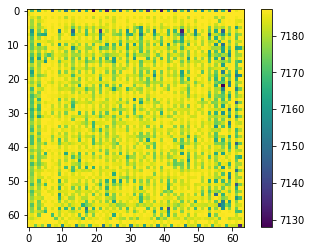

In [47]:
def show(img,mu,sigma):
    transform_inv = ComposeState([
        T.Lambda(lambda x: T.Normalize(torch.zeros(4),1/sigma)(x) if x.shape[0] == mu.shape[0] else x),
        T.Lambda(lambda x: T.Normalize(-mu,torch.ones(4))(x) if x.shape[0] == mu.shape[0] else x),
])
    
    img = transform_inv(img[0])
    
    img = img[0].cpu().detach()

    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.plot
    
mu_emulated, sigma_emulated = torch.Tensor([4107.4971, 4125.8013, 4125.2690, 4113.7964]), torch.Tensor([1.2752, 3.4878, 3.5042, 2.4178])
mu_original, sigma_original = torch.Tensor([6776.0562, 11890.2090, 11909.4814,  8562.4102]), torch.Tensor([411.0344, 1111.1176, 1115.3711,  775.2478])
    
show(x,mu_original,sigma_original)
show(y,mu_emulated,sigma_emulated)
show(pred,mu_original,sigma_original)